# Single PSF optical systems under Gaussian and Poissonian Noise proccesses

In [1]:
import jax
import jax.numpy as np
from jax import jit, vmap, grad, value_and_grad, hessian
from jax.ops import index, index_update
from jax.scipy.stats import poisson, norm
from jax.scipy.signal import convolve2d

from jax.config import config
config.update("jax_enable_x64", True)

In [2]:
import morphine as mp
import morphine.zernike as Z

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt

import numpy as onp

from scipy.stats import multivariate_normal
from scipy.ndimage import gaussian_filter, zoom

In [3]:
print(jax.__version__)
print(mp.__version__)

0.1.77
0.9.3


In [4]:
#####################
### Pupil Loading ###
#####################

def get_aperture(size, radius=None):
    """
    Produces an array to be used to represent the magnitude of light at the aperture of a telescope.
    Ie an array of zeros with a circle of ones at the centre
    Parameters:
        size: The size of the array to return
        radius (optional): The radius which defines the boundary of the aperture, if left as None it
        will extend the aperture to the edged of the array (ie radius = size/2)
    Returns:
        aperture: An array of zeros with a circular section in the middle of ones
    """
    c = size/2
    xs = np.linspace(-c, c, size, endpoint=False)
    Xs, Ys = np.meshgrid(xs, xs)
    Rs = np.hypot(Xs, Ys)
    
    if radius is None:
        aperture = np.where(Rs > c, 0, np.ones([size, size]))
    else:
        aperture = np.where(Rs > radius, 0, np.ones([size, size]))
    return aperture

def get_toliman_pupil(size, path=None):
    """
    Loads in the Toliman pupil file and returns a scaled version of dimension 'size'. 
    The pupil is returned as a complex array.
    Parameters:
        size: The size of the final output array
        path (optional): The path to the "Toliman_pupil.npy" file. If left as None it will
        look for the file in the current working directory
    Returns:
        toliman_pupil_scaled: A scaled version of the Toliman pupil returned as a complex array
    """
    if path is None:
        toliman_pupil = np.load("Toliman_pupil.npy")
    else:
        toliman_pupil = np.load("{}/Toliman_pupil.npy".format(path))
        
    phase = np.angle(toliman_pupil)
    size_in = phase.shape[0]
    ratio = float(size/size_in)
    phase_scaled = zoom(phase, ratio, order=0)
    toliman_pupil_out = get_aperture(size) * np.exp(1j * phase_scaled)
    return toliman_pupil_out

In [5]:
################################
### Morphine Optical Systems ###
################################

def get_toliman_osys(aperture, pupil_npix, pupil, npix, pix_size, fl, wl, sigma=0):
    """
    
    """
    # Optical System
    osys = mp.OpticalSystem(npix=pupil_npix)
    osys.pupil_diameter = aperture
    osys.sigma = sigma
    
    # Diffractive pupil/Aperture
    phases = np.abs(np.angle(pupil))
    binary_phases = phases/np.max(phases)
    osys.add_pupil(mp.ArrayOpticalElement(
            opd = binary_phases*wl/2,
            transmission = np.abs(pupil),
            pixelscale = aperture/pupil_npix),
            name = "Diffractive Pupil")

    # Detector
    pixelscale = 3600*180*np.arctan2(pix_size, fl)/np.pi # arcsec per pixel
    osys.add_detector(pixelscale=pixelscale, fov_pixels=npix//2)
    return osys

def get_airy_osys(aperture, pupil_npix, npix, pix_size, fl, sigma=0):
    """
    
    """
    # Optical System
    osys = mp.OpticalSystem(npix=pupil_npix)
    osys.pupil_diameter = aperture
    osys.sigma = sigma
    
    # Aperture
    osys.add_pupil(mp.CircularAperture(radius=aperture/2))
    
    # Detector
    pixelscale = 3600*180*np.arctan2(pix_size, fl)/np.pi # arcsec per pixel
    osys.add_detector(pixelscale=pixelscale, fov_pixels=npix//2)
    return osys

class Diffuser_optic:

    def __init__(self, npix, variance, power):
        self.planes = [Planes(npix)]
        self.source_offset_r = 0
        self.source_offset_theta = 0
        self.detector_npix = npix
        self.variance = variance # Defines shape
        self.power = power
        self.sigma = 0 # Defines Blur level
        
    def propagate_mono(self, wl):
        x = -2 * self.source_offset_r * np.sin(self.source_offset_theta*np.pi/180)
        y = -2 * self.source_offset_r * np.cos(self.source_offset_theta*np.pi/180)

        xs = np.linspace(-self.detector_npix-x, self.detector_npix-x, 2*self.detector_npix, endpoint=False)
        ys = np.linspace(-self.detector_npix+y, self.detector_npix+y, 2*self.detector_npix, endpoint=False)
        XX, YY = np.meshgrid(xs, ys)
        exponent = ((XX)**2/(2*self.variance**2) + (YY)**2/(2*self.variance**2))**self.power
        G = np.exp(-exponent)
        G = G/np.sum(G)
        
        c = int(self.detector_npix/2)
        G = G[self.detector_npix-c:self.detector_npix+c, self.detector_npix-c:self.detector_npix+c]
        G_out = Fplane(G)
        return [G_out]
    
class Fplane:
    def __init__(self, G):
        self.intensity = G
    
class Planes:
    def __init__(self, npix):
        self.fov_pixels = npix//2
        self.pixelscale = 1

In [6]:
###########################
### Modelling Functions ###
###########################

def get_psf(x, y, osys, wl):
    """
    coords = [x, y]
    
    NOTE: This assumes that the last object in the osys.planes list is the detector plane
    """
    r = np.hypot(x, y) * osys.planes[-1].pixelscale / 2 # Seems to be some factor of 2 problem somewhere
    theta = 180 * np.arctan2(-x, -y) / np.pi
    osys.source_offset_r = r # arcseconds
    osys.source_offset_theta = theta # degrees
    psf = osys.propagate_mono(wl)[0].intensity
    if osys.sigma == 0:
        return psf
    else:
        return blur(psf, osys.sigma)
    
def blur(image, sigma):
    size = np.ceil(sigma).astype(np.int16)
    x = np.linspace(-3*size, 3*size, 6*size+1)
    window = norm.pdf(x, scale=sigma) * norm.pdf(x[:, None], scale=sigma)
    blurred_image = convolve2d(image, window, mode='same')
    return blurred_image

In [7]:
##########################
### Bayesian Functions ###
##########################

def get_likelihood(X, chi2_func, *args):
    return np.exp(-0.5*chi2_func(X, *args))

def get_log_likelihod(X, chi2_func, *args):
    return -0.5*chi2_func(X, *args)
get_log_posterior_hessian = hessian(get_log_likelihod)

def get_covariance_matrix(X, chi2_func, *args):
    LPH = get_log_posterior_hessian(X, chi2_func, *args)
    return -np.linalg.inv(LPH)

In [8]:
# Optical params
aperture = 0.02
pix_size = 2*1.12*1e-6 # 2x becuase bayer
npix = 256
pupil_npix = 512
fl = 0.15
wl = 500e-9

# Diffraction limit
dlim_rad = 1.22 * wl / aperture
dlim_pix = fl * np.tan(dlim_rad) / pix_size

# Diffuser Params
spatial_variance = 26
power = 3

/import/tintagel3/snert/louis/anaconda3/envs/morph/lib/python3.8/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [9]:
# Load in pupil
pupil = get_toliman_pupil(pupil_npix)

# Construct Optical Systems
Toliman = get_toliman_osys(aperture, pupil_npix, pupil, npix, pix_size, fl, wl)
Toliman_2 = get_toliman_osys(aperture, pupil_npix, pupil, npix, pix_size, fl, wl, sigma=2)
Airy = get_airy_osys(aperture, pupil_npix, npix, pix_size, fl)
Diffuser = Diffuser_optic(npix, spatial_variance, power)

osyses = [Airy, Toliman, Toliman_2, Diffuser]
osys_names = ["Airy", "Toliman", "Toliman 2", "Diffuser"]

## Observe Optical Systems

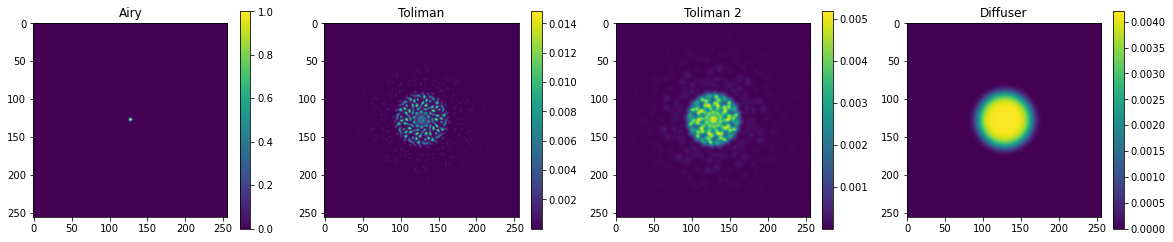

In [10]:
psfs = []
for i in range(len(osyses)):
    psfs.append(get_psf(0, 0, osyses[i], wl))

plt.figure(figsize=(20, 4))
for i in range(len(osyses)):
    plt.subplot(1, 4, i+1)
    plt.imshow(psfs[i]/np.max(psfs[0]))
    plt.colorbar()
    plt.title(osys_names[i])
plt.show()

---

## Gaussian additive noise

Verify Laplace Approximation

In [11]:
def get_chi2_x(X, noise, osys, wl, flux=1e3):
    """
    BIG NOTE: If you pass in coordinate values of 0 something dies along the way when evaluating gradients.
    I assume something seems to feed that into a denominator as it only returns nans or inf
    I should post this as a jax bug so jake can tell me why im dumb
    """
    x = X[0]
    data  = flux*get_psf(1, 1, osys, wl)
    model = flux*get_psf(1+x, 1, osys, wl)
    chi2 = np.sum(np.square((model-data)/noise)) 
    return chi2

In [13]:
noise = 1
Nxs = 100
xs_airy =  np.linspace(-0.07, 0.07, Nxs, endpoint=False)
xs_tol =   np.linspace(-0.5, 0.5, Nxs, endpoint=False)
xs_tol_2 = np.linspace(-3.5, 3.5, Nxs, endpoint=False)
xs_diff =  np.linspace(-7.5, 7.5, Nxs, endpoint=False)
xs_all = [xs_airy, xs_tol, xs_tol_2, xs_diff]
gauss_astro_likelihoods = []

for i in range(len(osyses)):
    temp = []
    for j in tqdm(range(Nxs)):
        X = np.array([xs_all[i][j]])
        temp.append(get_likelihood(X, get_chi2_x, noise, osyses[i], wl))
    gauss_astro_likelihoods.append(temp)
gauss_astro_likelihoods = np.array(gauss_astro_likelihoods)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [15]:
gauss_astro_laplace = []
for i in tqdm(range(len(osyses))):
    X = np.array([0.])
    cov_mat = get_covariance_matrix(X, get_chi2_x, noise, osyses[i], wl)
    variances = np.sqrt(np.diag(cov_mat))
    raw_pdf = multivariate_normal(cov=variances[0]**2).pdf(xs_all[i])
    pdf = raw_pdf/np.max(raw_pdf)
    gauss_astro_laplace.append(pdf)

  0%|          | 0/4 [00:00<?, ?it/s]

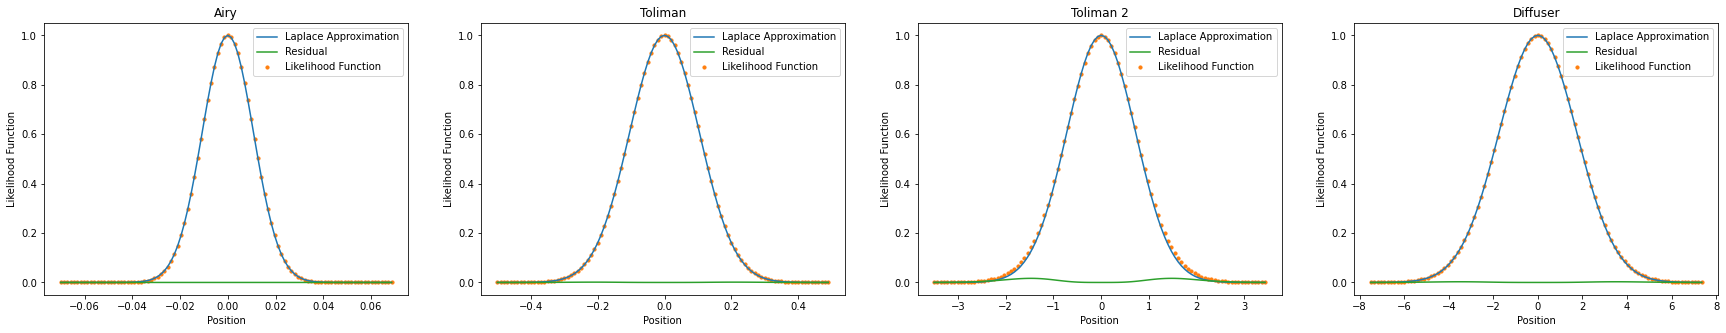

In [16]:
plt.figure(figsize=(30, 5))
for i in range(len(osyses)):
    plt.subplot(1, 4, i+1)
    plt.title("{}".format(osys_names[i]))
    plt.plot(xs_all[i], gauss_astro_laplace[i], label="Laplace Approximation", c='tab:blue')
    plt.scatter(xs_all[i], gauss_astro_likelihoods[i, :], label="Likelihood Function", c="tab:orange", alpha=1, s=10)
    plt.plot(xs_all[i], gauss_astro_likelihoods[i, :] - gauss_astro_laplace[i], label="Residual", c="tab:green")
    plt.legend(loc=1)
    plt.ylabel("Likelihood Function")
    plt.xlabel("Position")
plt.show()

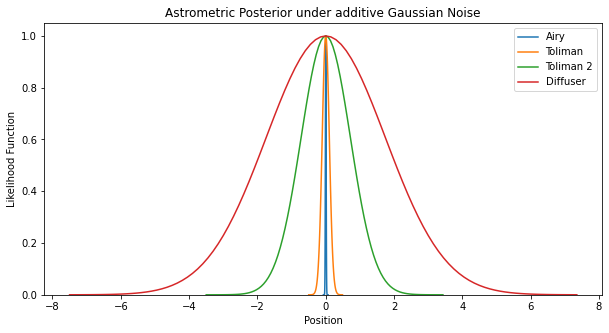

In [17]:
plt.figure(figsize=(10, 5))

plt.title("Astrometric Posterior under additive Gaussian Noise".format(osys_names[i]))
for i in range(len(osyses)):
    plt.plot(xs_all[i], gauss_astro_laplace[i], label=osys_names[i])
plt.legend()
plt.ylim(0)
plt.ylabel("Likelihood Function")
plt.xlabel("Position")
plt.show()

In [18]:
X = np.array([0.])
gauss_astro_variances = []
noises = np.linspace(0, 10)
for i in range(len(osyses)):
    temp = []
    for j in tqdm(range(len(noises))):
        covariance_matrix = get_covariance_matrix(X, get_chi2_x, noises[j], osyses[i], wl)
        variances = np.sqrt(np.diag(covariance_matrix))
        temp.append(variances)
    gauss_astro_variances.append(temp)
gauss_astro_variances = np.array(gauss_astro_variances)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

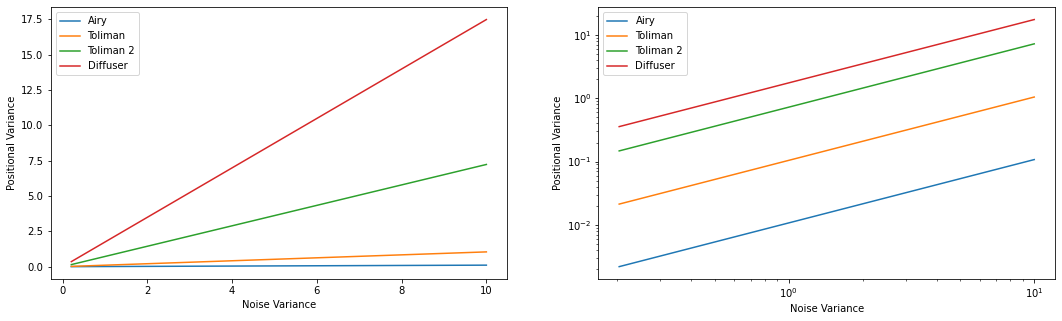

In [19]:
plt.figure(figsize=(18, 5))
plt.subplot(1, 2, 1)
for i in range(len(X)):
    for j in range(len(osyses)):
        plt.plot(noises, gauss_astro_variances[j, :, i], label=osys_names[j])
    plt.legend()
    plt.ylabel("Positional Variance")
    plt.xlabel("Noise Variance")
    
plt.subplot(1, 2, 2)
for i in range(len(X)):
    for j in range(len(osyses)):
        plt.plot(noises, gauss_astro_variances[j, :, i], label=osys_names[j])
    plt.legend()
    plt.ylabel("Positional Variance")
    plt.xlabel("Noise Variance")
    plt.yscale('log')
    plt.xscale('log')
plt.show()

---

## Flux under additive Gaussian noise


In [20]:
def get_chi2_f(X, noise, osys, wl, flux_base=1e3):
    """
    BIG NOTE: If you pass in coordinate values of 0 something dies along the way when evaluating gradients.
    I assume something seems to feed that into a denominator as it only returns nans or inf
    I should post this as a jax bug so jake can tell me why im dumb
    """
    flux = X[0]
    data =       flux_base*get_psf(1, 1, osys, wl)
    model = flux*flux_base*get_psf(1, 1, osys, wl)
    chi2 = np.sum(np.square((model-data)/noise)) 
    return chi2

In [21]:
noise = 1
Nfs = 100
fs_airy = np.linspace(0.975, 1.025, Nfs, endpoint=False)
fs_tol = np.linspace(0.8, 1.2, Nfs, endpoint=False)
fs_tol_2 = np.linspace(0.6, 1.4, Nfs, endpoint=False)
fs_diff = np.linspace(0.4, 1.6, Nfs, endpoint=False)
fs_all = np.array([fs_airy, fs_tol, fs_tol_2, fs_diff])

In [22]:
gauss_photo_likelihood = []
for i in range(len(osyses)):
    temp = []
    for j in tqdm(range(Nfs)):
        X = np.array([fs_all[i, j]])
        temp.append(get_likelihood(X, get_chi2_f, noise, osyses[i], wl))
    gauss_photo_likelihood.append(temp)
gauss_photo_likelihood = np.array(gauss_photo_likelihood)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [24]:
gauss_photo_laplace = []
for i in tqdm(range(len(osyses))):
    X = np.array([1.])
    cov_mat = get_covariance_matrix(X, get_chi2_f, noise, osyses[i], wl)
    variances = np.sqrt(np.diag(cov_mat))
    raw_pdf = multivariate_normal(cov=variances[0]**2).pdf(fs_all[i]-1)
    pdf = raw_pdf/np.max(raw_pdf)
    gauss_photo_laplace.append(pdf)

  0%|          | 0/4 [00:00<?, ?it/s]

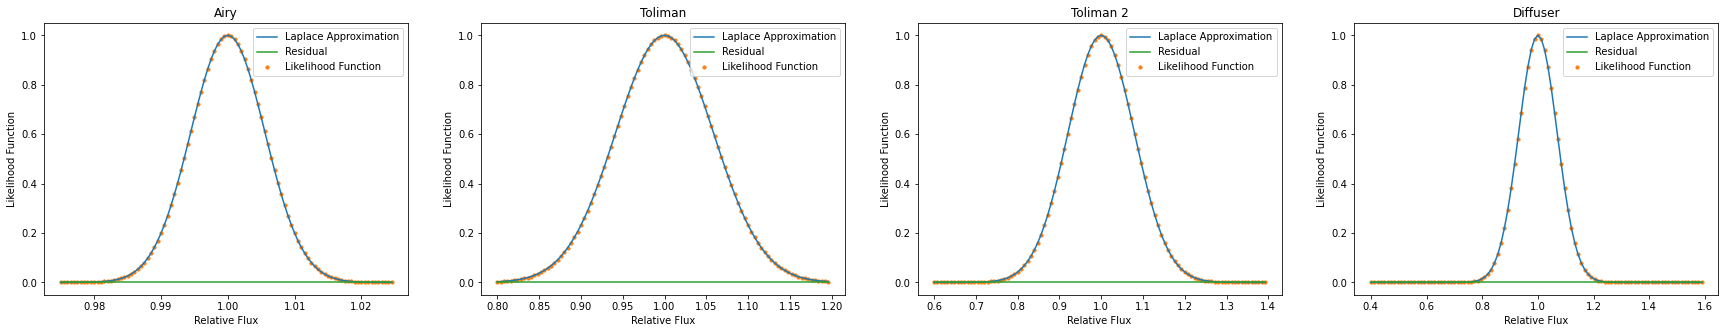

In [25]:
plt.figure(figsize=(30, 5))
for i in range(len(osyses)):
    plt.subplot(1, 4, i+1)
    plt.title("{}".format(osys_names[i]))
    plt.plot(fs_all[i], gauss_photo_laplace[i], label="Laplace Approximation", c='tab:blue')
    plt.scatter(fs_all[i], gauss_photo_likelihood[i, :], label="Likelihood Function", c="tab:orange", alpha=1, s=10)
    plt.plot(fs_all[i], gauss_photo_likelihood[i, :] - gauss_photo_laplace[i], label="Residual", c="tab:green")
    plt.legend(loc=1)
    plt.ylabel("Likelihood Function")
    plt.xlabel("Relative Flux")
plt.show()

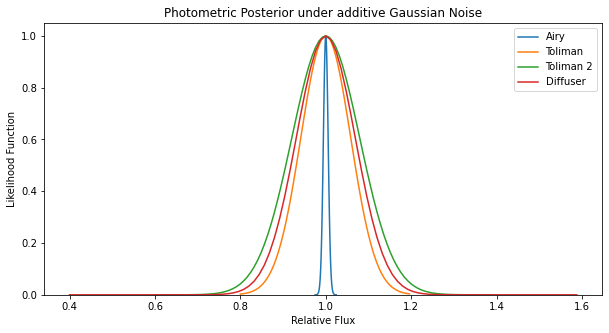

In [26]:
plt.figure(figsize=(10, 5))

plt.title("Photometric Posterior under additive Gaussian Noise".format(osys_names[i]))
for i in range(len(osyses)):
    plt.plot(fs_all[i], gauss_photo_laplace[i], label=osys_names[i])
plt.legend()
plt.ylim(0)
plt.ylabel("Likelihood Function")
plt.xlabel("Relative Flux")
plt.show()

In [27]:
X = np.array([1.])
gauss_photo_variances = []
noises = np.linspace(0, 10)
for i in range(len(osyses)):
    temp = []
    for j in tqdm(range(len(noises))):
        covariance_matrix = get_covariance_matrix(X, get_chi2_f, noises[j], osyses[i], wl)
        variances = np.sqrt(np.diag(covariance_matrix))
        temp.append(variances)
    gauss_photo_variances.append(temp)
gauss_photo_variances = np.array(gauss_photo_variances)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

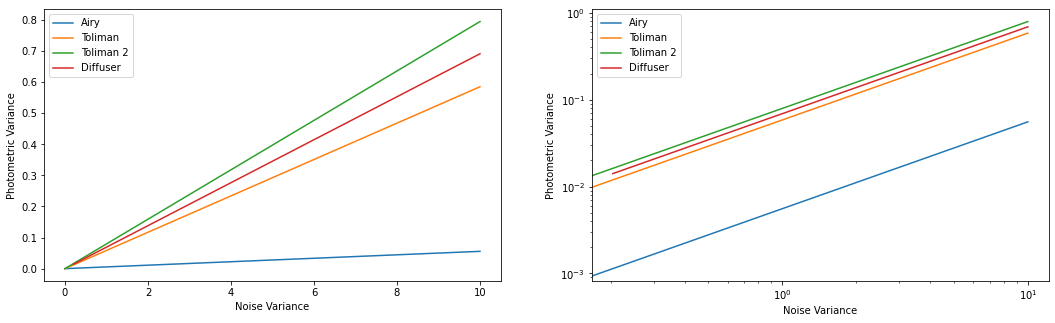

In [28]:
plt.figure(figsize=(18, 5))
plt.subplot(1, 2, 1)
for i in range(len(X)):
    for j in range(len(osyses)):
        plt.plot(noises, gauss_photo_variances[j, :, i], label=osys_names[j])
    plt.legend()
    plt.ylabel("Photometric Variance")
    plt.xlabel("Noise Variance")
    
plt.subplot(1, 2, 2)
for i in range(len(X)):
    for j in range(len(osyses)):
        plt.plot(noises, gauss_photo_variances[j, :, i], label=osys_names[j])
    plt.legend()
    plt.ylabel("Photometric Variance")
    plt.xlabel("Noise Variance")
    plt.yscale('log')
    plt.xscale('log')
plt.show()

---

# Poisson Noise

Astrometric Posterior

In [38]:
xpix = np.arange(-npix//2, npix//2)
XX, YY = np.meshgrid(xpix, xpix)
RR = np.hypot(XX, YY)
rmax = 75

In [39]:
def get_poiss(data, model):
    return np.sum(poisson.logpmf(data, model))

def get_poiss_x(X, flux, mask, osys, wl):
    x = X[0]
    data  = flux*get_psf(1,   1, osys, wl)[mask]
    model = flux*get_psf(1+x, 1, osys, wl)[mask]
    log_likeli = get_poiss(data, model) - get_poiss(data, data) # Subtract off the normalisation fact (subtract becuase log)
    return -log_likeli

def get_poiss_f(X, flux, mask, osys, wl):
    rel_flux = X[0]
    data  =          flux*get_psf(1, 1, osys, wl)[mask]
    model = rel_flux*flux*get_psf(1, 1, osys, wl)[mask]
    log_likeli = get_poiss(data, model) - get_poiss(data, data) # Subtract off the normalisation fact (subtract becuase log)
    return -log_likeli

In [40]:
Nxs = 100
flux = 1e3
xs_airy_poiss = np.linspace(-0.25, 0.25, Nxs, endpoint=False)
xs_tol_poiss = np.linspace(-0.25, 0.25, Nxs, endpoint=False)
xs_tol_2_poiss = np.linspace(-1.5, 1.5, Nxs, endpoint=False)
xs_diff_poiss = np.linspace(-1.5, 1.5, Nxs, endpoint=False)
xs_all_poiss = np.array([xs_airy_poiss, xs_tol_poiss, xs_tol_2_poiss, xs_diff_poiss])

In [41]:
poiss_astro_likelihood = []
for i in range(len(osyses)):
    temp = []
    for j in tqdm(range(Nxs)):
        X = np.array([xs_all_poiss[i, j]])
        P = get_likelihood(X, get_poiss_x, flux, RR<rmax, osyses[i], wl)
        temp.append(P)
    poiss_astro_likelihood.append(temp)
poiss_astro_likelihood = np.array(poiss_astro_likelihood)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [42]:
poiss_astro_laplace = []
for i in tqdm(range(len(osyses))):
    X = np.array([0.])
    cov_mat = get_covariance_matrix(X, get_poiss_x, flux, RR<rmax, osyses[i], wl)
    raw_pdf = multivariate_normal(cov=np.sqrt(cov_mat)[0]**2).pdf(xs_all_poiss[i])
    pdf = raw_pdf/np.max(raw_pdf)
    poiss_astro_laplace.append(pdf)

  0%|          | 0/4 [00:00<?, ?it/s]

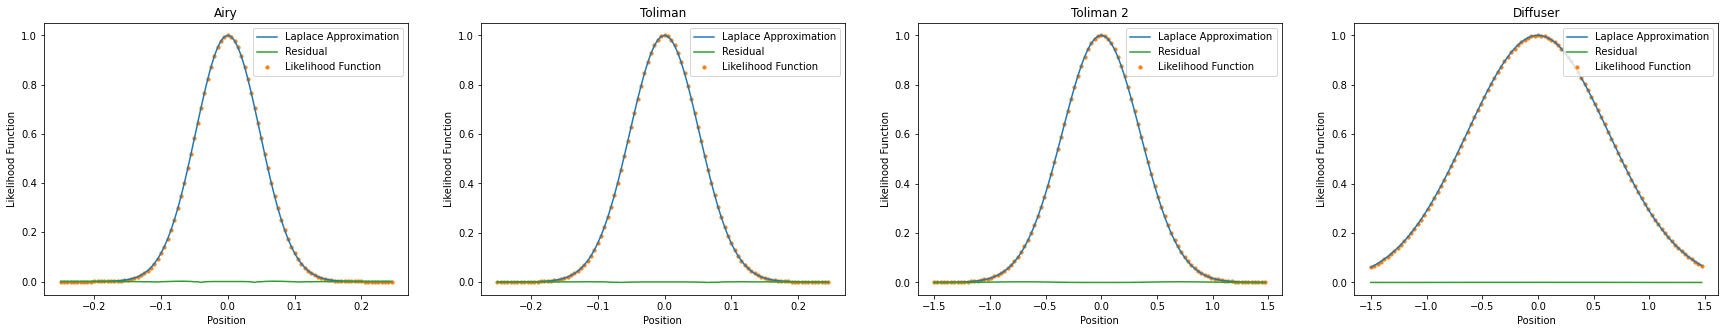

In [43]:
plt.figure(figsize=(30, 5))
for i in range(len(osyses)):
    plt.subplot(1, 4, i+1)
    plt.title("{}".format(osys_names[i]))
    plt.plot(xs_all_poiss[i], poiss_astro_laplace[i], label="Laplace Approximation", c='tab:blue')
    plt.scatter(xs_all_poiss[i], poiss_astro_likelihood[i, :], label="Likelihood Function", c="tab:orange", alpha=1, s=10)
    plt.plot(xs_all_poiss[i], poiss_astro_likelihood[i, :] - poiss_astro_laplace[i], label="Residual", c="tab:green")
    plt.legend(loc=1)
    plt.ylabel("Likelihood Function")
    plt.xlabel("Position")
plt.show()

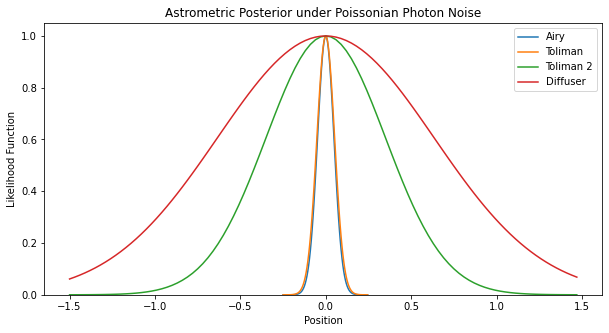

In [44]:
plt.figure(figsize=(10, 5))

plt.title("Astrometric Posterior under Poissonian Photon Noise".format(osys_names[i]))
for i in range(len(osyses)):
    plt.plot(xs_all_poiss[i], poiss_astro_laplace[i], label=osys_names[i])
plt.legend()
plt.ylim(0)
plt.ylabel("Likelihood Function")
plt.xlabel("Position")
plt.show()

In [46]:
X = np.array([0.])
poiss_astro_variances = []
fluxes = np.array([1e1, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7, 1e8])
for i in tqdm(range(len(osyses))):
    temp = []
    for j in range(len(fluxes)):
        cov_mat = get_covariance_matrix(X, get_poiss_x, fluxes[j], RR<rmax, osyses[i], wl)
        temp.append(np.sqrt(cov_mat[0][0]))
    poiss_astro_variances.append(temp)
poiss_astro_variances = np.array(poiss_astro_variances)

  0%|          | 0/4 [00:00<?, ?it/s]

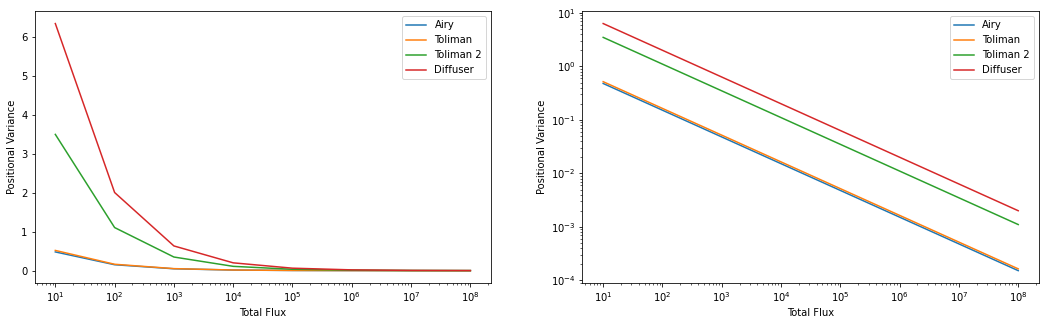

In [47]:
plt.figure(figsize=(18, 5))
plt.subplot(1, 2, 1)
for i in range(len(osyses)):
    plt.plot(fluxes, poiss_astro_variances[i], label=osys_names[i])
plt.legend()
plt.ylabel("Positional Variance")
plt.xlabel("Total Flux")
plt.xscale('log')
    
plt.subplot(1, 2, 2)
for i in range(len(osyses)):
    plt.plot(fluxes, poiss_astro_variances[i], label=osys_names[i])
plt.legend()
plt.ylabel("Positional Variance")
plt.xlabel("Total Flux")
plt.yscale('log')
plt.xscale('log')
plt.show()

---

Putting together in a Fig

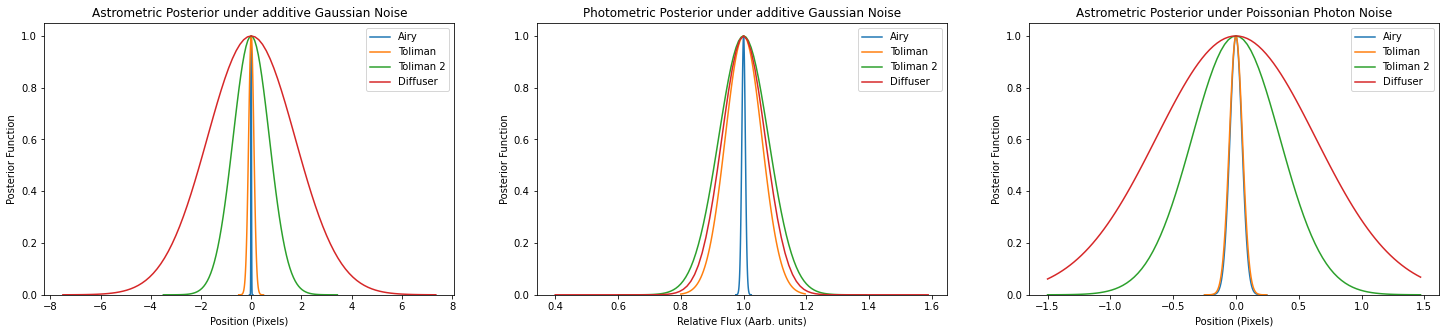

In [50]:
plt.figure(figsize=(25, 5))
plt.subplot(1, 3, 1)
plt.title("Astrometric Posterior under additive Gaussian Noise".format(osys_names[i]))
for i in range(len(osyses)):
    plt.plot(xs_all[i], gauss_astro_laplace[i], label=osys_names[i])
plt.legend()
plt.ylim(0)
plt.ylabel("Posterior Function")
plt.xlabel("Position (Pixels)")

plt.subplot(1, 3, 2)
plt.title("Photometric Posterior under additive Gaussian Noise".format(osys_names[i]))
for i in range(len(osyses)):
    plt.plot(fs_all[i], gauss_photo_laplace[i], label=osys_names[i])
plt.legend()
plt.ylim(0)
plt.ylabel("Posterior Function")
plt.xlabel("Relative Flux (Aarb. units)")

plt.subplot(1, 3, 3)
plt.title("Astrometric Posterior under Poissonian Photon Noise".format(osys_names[i]))
for i in range(len(osyses)):
    plt.plot(xs_all_poiss[i], poiss_astro_laplace[i], label=osys_names[i])
plt.legend()
plt.ylim(0)
plt.ylabel("Posterior Function")
plt.xlabel("Position (Pixels)")
plt.show()

---

## (Ignore Below)

Photometric constraint under poissonian noise (its a poissonian distribution duh)

In [74]:
noise = 1
Nfs = 50
# fs_airy = np.linspace(0.975, 1.025, Nfs, endpoint=False)
# fs_tol = np.linspace(0.8, 1.2, Nfs, endpoint=False)
# fs_tol_2 = np.linspace(0.6, 1.4, Nfs, endpoint=False)
# fs_diff = np.linspace(0.4, 1.6, Nfs, endpoint=False)
fs_airy =  np.linspace(0.8, 1.2, Nfs, endpoint=False)
fs_tol =   np.linspace(0.8, 1.2, Nfs, endpoint=False)
fs_tol_2 = np.linspace(0.8, 1.2, Nfs, endpoint=False)
fs_diff =  np.linspace(0.8, 1.2, Nfs, endpoint=False)
fs_all = np.array([fs_airy, fs_tol, fs_tol_2, fs_diff])

In [77]:
out = []
for i in range(len(osyses)):
    temp = []
    for j in tqdm(range(Nfs)):
        X = np.array([fs_all[i, j]])
        temp.append(get_likelihood(X, chi2_poiss_f, 1e3, RR<rmax, osyses[i], wl))
    out.append(temp)
out = np.array(out)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

In [78]:
laplace_approx = []
for i in tqdm(range(len(osyses))):
    X = np.array([1.])
    cov_mat = get_covariance_matrix(X, chi2_poiss_f, 1e3, RR<rmax, osyses[i], wl)
    variances = np.sqrt(np.diag(cov_mat))
    raw_pdf = multivariate_normal(cov=variances[0]**2).pdf(fs_all[i]-1)
    pdf = raw_pdf/np.max(raw_pdf)
    laplace_approx.append(pdf)

  0%|          | 0/4 [00:00<?, ?it/s]

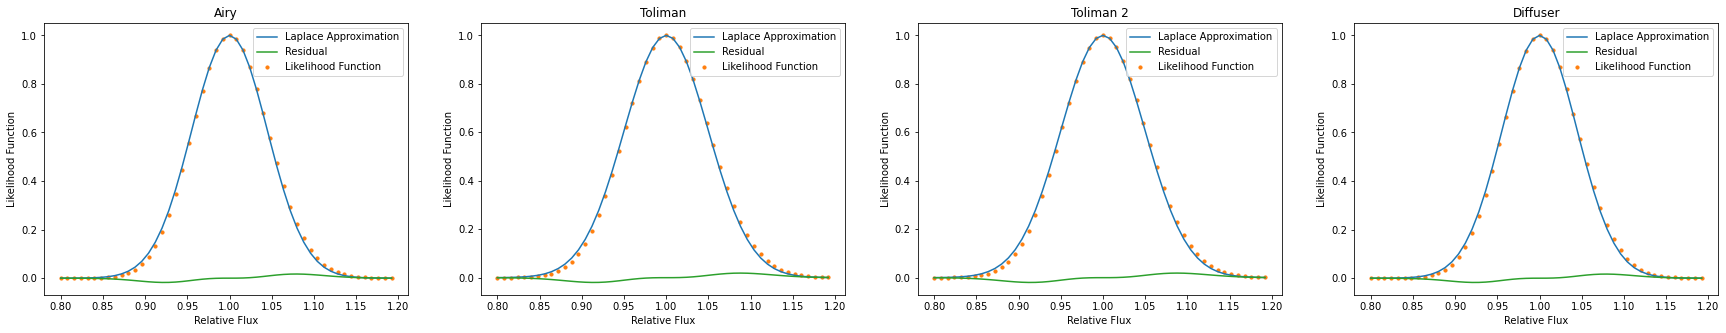

In [79]:
plt.figure(figsize=(30, 5))
for i in range(len(osyses)):
    plt.subplot(1, 4, i+1)
    plt.title("{}".format(osys_names[i]))
    plt.plot(fs_all[i], laplace_approx[i], label="Laplace Approximation", c='tab:blue')
    plt.scatter(fs_all[i], out[i, :], label="Likelihood Function", c="tab:orange", alpha=1, s=10)
    plt.plot(fs_all[i], out[i, :] - laplace_approx[i], label="Residual", c="tab:green")
    plt.legend(loc=1)
    plt.ylabel("Likelihood Function")
    plt.xlabel("Relative Flux")
plt.show()

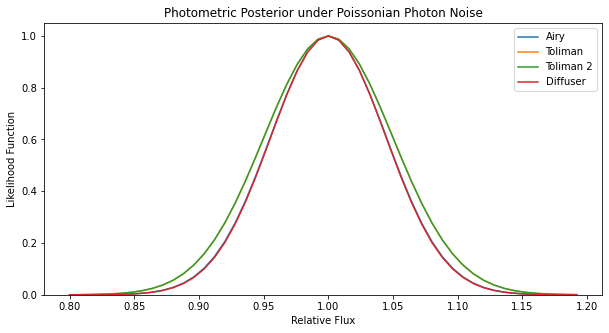

In [98]:
plt.figure(figsize=(10, 5))

plt.title("Photometric Posterior under Poissonian Photon Noise".format(osys_names[i]))
for i in range(len(osyses)):
    plt.plot(fs_all[i], laplace_approx[i], label=osys_names[i])
plt.legend()
plt.ylim(0)
plt.ylabel("Likelihood Function")
plt.xlabel("Relative Flux")
plt.show()

In [83]:
X = np.array([1.])
variances_out = []
fluxes = np.array([1e1, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7, 1e8])
for i in range(len(osyses)):
    temp = []
    for j in tqdm(range(len(fluxes))):
        covariance_matrix = get_covariance_matrix(X, chi2_poiss_f, fluxes[j], RR<rmax, osyses[i], wl)
        variances = np.sqrt(np.diag(covariance_matrix))
        temp.append(variances)
    variances_out.append(temp)
variances_out = np.array(variances_out)

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

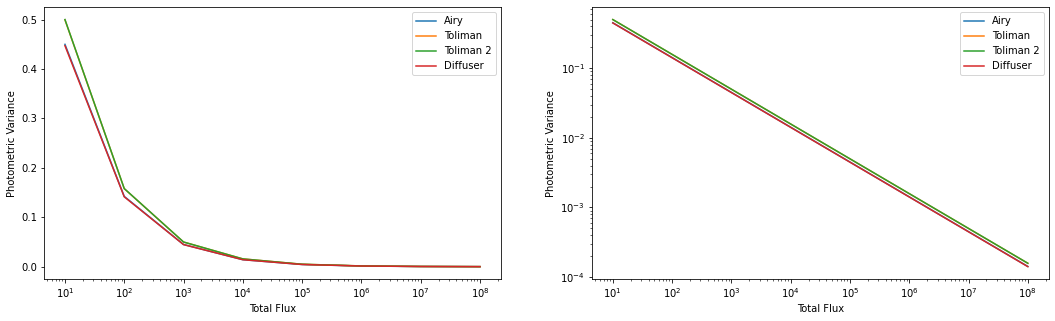

In [89]:
plt.figure(figsize=(18, 5))
plt.subplot(1, 2, 1)
for i in range(len(X)):
    for j in range(len(osyses)):
        plt.plot(fluxes, variances_out[j, :, i], label=osys_names[j])
    plt.legend()
    plt.ylabel("Photometric Variance")
    plt.xlabel("Total Flux")
    plt.xscale('log')
    
plt.subplot(1, 2, 2)
for i in range(len(X)):
    for j in range(len(osyses)):
        plt.plot(fluxes, variances_out[j, :, i], label=osys_names[j])
    plt.legend()
    plt.ylabel("Photometric Variance")
    plt.xlabel("Total Flux")
    plt.yscale('log')
    plt.xscale('log')
plt.show()